In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [31]:
class TimeDiffLSTM(tf.keras.Model):
    def __init__(self, hidden_units=64, dropout_rate=0.2):
        super(TimeDiffLSTM, self).__init__()
        
        # LSTM for sequence processing
        self.lstm_layer = layers.LSTM(hidden_units, 
                                      return_sequences=True, 
                                      dropout=dropout_rate,
                                      recurrent_dropout=dropout_rate)
        
        # Bidirectional LSTM for capturing both forward and backward dependencies
        self.bi_lstm = layers.Bidirectional(
            layers.LSTM(hidden_units, return_sequences=True)
        )
        
        # Attention mechanism for focusing on important steps
        self.attention = layers.MultiHeadAttention(
            num_heads=4, key_dim=hidden_units
        )
        self.layer_norm = layers.LayerNormalization()
        
        # Output heads
        self.time_diff_head = layers.Dense(1)  # For each step time prediction
        self.total_time_head = layers.Dense(1, activation='relu')  # For total time prediction
        
    def call(self, inputs):
        # Process sequence with LSTM
        lstm_out = self.lstm_layer(inputs)
        
        # Apply bidirectional LSTM for more context
        bi_lstm_out = self.bi_lstm(lstm_out)
        
        # Apply attention mechanism
        attn_out = self.attention(bi_lstm_out, bi_lstm_out, bi_lstm_out)
        attn_out = self.layer_norm(attn_out + bi_lstm_out)
        
        # Generate refined time differences for each step
        time_diffs = self.time_diff_head(attn_out)
        time_diffs = tf.squeeze(time_diffs, axis=-1)
        
        # Ensure non-negative values
        time_diffs = tf.nn.relu(time_diffs)
        
        # Generate total time prediction
        sequence_encoding = tf.reduce_mean(attn_out, axis=1)
        total_time = self.total_time_head(sequence_encoding)
        
        # Calculate cumulative times
        cumulative_times = tf.cumsum(time_diffs, axis=1)
        
        return time_diffs, total_time, cumulative_times

In [32]:
def process_transformer_predictions(transformer_predictions_file):
    """
    Process the transformer predictions CSV to prepare data for LSTM training
    """
    # Load the predictions CSV
    df = pd.read_csv(transformer_predictions_file)
    
    # Extract unique sequences
    sequences = df['Sequence'].unique()
    
    # Initialize lists to store data
    X_data = []  # Input features for LSTM
    y_increments = []  # Ground truth time increments
    y_cumulative = []  # Ground truth cumulative times
    masks = []  # Masks for valid data
    
    # Process each sequence
    for seq in sequences:
        seq_data = df[df['Sequence'] == seq].sort_values('Step')
        
        # Extract features (proportion, sourceID, step position)
        features = np.column_stack([
            seq_data['Predicted_Proportion'].values,  # Transformer proportions
            seq_data['GroundTruth_Increment'].values,  # Ground truth increments
            seq_data['GroundTruth_Cumulative'].values,  # Ground truth cumulative
            seq_data['Step'].values / max(seq_data['Step'].values)  # Normalized step position
        ])
        
        # Get ground truth values
        increments = seq_data['GroundTruth_Increment'].values
        cumulative = seq_data['GroundTruth_Cumulative'].values
        
        # Add to lists
        X_data.append(features)
        y_increments.append(increments)
        y_cumulative.append(cumulative)
        masks.append(np.ones(len(features)))  # All data is valid
    
    # Calculate maximum sequence length
    max_length = max(len(x) for x in X_data)
    
    # Pad sequences to same length
    X_padded = np.zeros((len(X_data), max_length, X_data[0].shape[1]))
    y_increments_padded = np.zeros((len(y_increments), max_length))
    y_cumulative_padded = np.zeros((len(y_cumulative), max_length))
    masks_padded = np.zeros((len(masks), max_length))
    
    for i in range(len(X_data)):
        seq_len = len(X_data[i])
        X_padded[i, :seq_len, :] = X_data[i]
        y_increments_padded[i, :seq_len] = y_increments[i]
        y_cumulative_padded[i, :seq_len] = y_cumulative[i]
        masks_padded[i, :seq_len] = masks[i]
    
    # Extract total times (final cumulative value for each sequence)
    y_total_times = np.array([seq[-1] if len(seq) > 0 else 0 for seq in y_cumulative])
    
    return {
        'X': X_padded,
        'y_increments': y_increments_padded,
        'y_cumulative': y_cumulative_padded,
        'y_total_times': y_total_times,
        'masks': masks_padded,
        'sequences': sequences,
        'df': df  # Original dataframe for later reference
    }

In [33]:
def custom_masked_loss(mask):
    """
    Create a custom loss function that only considers valid tokens (not padding)
    """
    def masked_mse(y_true, y_pred):
        # Ensure shapes are compatible before multiplication
        # Reshape the mask to match y_true and y_pred dimensions
        mask_float = tf.cast(mask, tf.float32)
        
        # Get the actual batch size from the current inputs
        current_batch_size = tf.shape(y_true)[0]
        
        # Make sure we use the correct portion of the mask for the current batch
        # This handles the batch size mismatch
        mask_batch = mask_float[:current_batch_size]
        
        # Apply mask to predictions and ground truth
        masked_y_true = y_true * mask_batch
        masked_y_pred = y_pred * mask_batch
        
        # Compute MSE only for valid tokens
        squared_error = tf.square(masked_y_true - masked_y_pred)
        valid_tokens = tf.reduce_sum(mask_batch, axis=1, keepdims=True)
        valid_tokens = tf.where(valid_tokens == 0, tf.ones_like(valid_tokens), valid_tokens)
        
        # Normalize by number of valid tokens
        mse = tf.reduce_sum(squared_error, axis=1, keepdims=True) / valid_tokens
        return tf.reduce_mean(mse)
    
    return masked_mse

In [34]:
def train_lstm_from_transformer_predictions(transformer_predictions_file, epochs=50, batch_size=32):
    """
    Train LSTM model using transformer predictions CSV file
    """
    # Process transformer predictions
    data = process_transformer_predictions(transformer_predictions_file)
    
    # Create and compile LSTM model
    lstm_model = TimeDiffLSTM()
    
    # Initial call to build the model
    _ = lstm_model(data['X'])
    
    # Custom masked loss for time differences
    masked_mse = custom_masked_loss(data['masks'])
    
    # Compile the model
    lstm_model.compile(
        optimizer=Adam(learning_rate=0.005),
        loss=[masked_mse, 'mse', masked_mse],  # Losses for time_diffs, total_time, cumulative_times
        loss_weights=[0.4, 0.3, 0.3]  # Weights for each loss component
    )
    
    # Prepare target data for training
    y_train = [
        data['y_increments'],
        data['y_total_times'],
        data['y_cumulative']
    ]
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Train the model
    history = lstm_model.fit(
        data['X'],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    return lstm_model, history, data

In [35]:
def generate_lstm_predictions_from_transformer_csv(lstm_model, data):
    """
    Generate predictions using the LSTM model trained on transformer predictions
    """
    # Get LSTM predictions
    time_diffs_pred, total_time_pred, cumulative_times_pred = lstm_model(data['X'])
    
    # Convert to numpy for further processing
    time_diffs_pred = time_diffs_pred.numpy()
    total_time_pred = total_time_pred.numpy()
    cumulative_times_pred = cumulative_times_pred.numpy()
    
    # Create results dataframe with both transformer and LSTM predictions
    results_list = []
    
    # Original dataframe with transformer predictions
    original_df = data['df']
    
    # Process each sequence
    for seq_idx, seq in enumerate(data['sequences']):
        seq_data = original_df[original_df['Sequence'] == seq].sort_values('Step')
        
        # Get number of steps in this sequence
        seq_steps = len(seq_data)
        
        # Add LSTM predictions
        seq_data = seq_data.copy()
        seq_data['LSTM_Predicted_TimeDiff'] = time_diffs_pred[seq_idx, :seq_steps]
        seq_data['LSTM_Predicted_Cumulative'] = cumulative_times_pred[seq_idx, :seq_steps]
        seq_data['LSTM_Predicted_TotalTime'] = total_time_pred[seq_idx, 0]
        
        # Calculate improvement metrics
        seq_data['TimeDiff_Improvement_Pct'] = (
            (abs(seq_data['GroundTruth_Increment'] - seq_data['Predicted_Increment']) - 
             abs(seq_data['GroundTruth_Increment'] - seq_data['LSTM_Predicted_TimeDiff'])) / 
             abs(seq_data['GroundTruth_Increment'] - seq_data['Predicted_Increment']) * 100
        ).fillna(0)
        
        seq_data['Cumulative_Improvement_Pct'] = (
            (abs(seq_data['GroundTruth_Cumulative'] - seq_data['Predicted_Cumulative']) - 
             abs(seq_data['GroundTruth_Cumulative'] - seq_data['LSTM_Predicted_Cumulative'])) / 
             abs(seq_data['GroundTruth_Cumulative'] - seq_data['Predicted_Cumulative']) * 100
        ).fillna(0)
        
        results_list.append(seq_data)
    
    # Combine all results
    results_df = pd.concat(results_list, ignore_index=True)
    results_df.to_csv('predictions_lstm_refined.csv', index=False)
    print("Combined predictions saved to predictions_lstm_refined.csv")
    
    # Calculate overall improvement statistics
    transformer_time_diff_mae = np.mean(abs(results_df['GroundTruth_Increment'] - results_df['Predicted_Increment']))
    lstm_time_diff_mae = np.mean(abs(results_df['GroundTruth_Increment'] - results_df['LSTM_Predicted_TimeDiff']))
    
    transformer_cumulative_mae = np.mean(abs(results_df['GroundTruth_Cumulative'] - results_df['Predicted_Cumulative']))
    lstm_cumulative_mae = np.mean(abs(results_df['GroundTruth_Cumulative'] - results_df['LSTM_Predicted_Cumulative']))
    
    print("\nModel Performance Comparison (Mean Absolute Error)")
    print(f"Time Differences: Transformer {transformer_time_diff_mae:.4f}, LSTM {lstm_time_diff_mae:.4f}, " 
          f"Improvement: {(1 - lstm_time_diff_mae/transformer_time_diff_mae)*100:.2f}%")
    
    print(f"Cumulative Times: Transformer {transformer_cumulative_mae:.4f}, LSTM {lstm_cumulative_mae:.4f}, "
          f"Improvement: {(1 - lstm_cumulative_mae/transformer_cumulative_mae)*100:.2f}%")
    
    return results_df

In [36]:
def visualize_results(results_df, data, lstm_model):
    """
    Generate visualizations to analyze model performance and predictions
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Set style
    plt.style.use('ggplot')
    
    # 1. Prediction Accuracy Comparison
    plt.figure(figsize=(15, 8))
    
    # Sample a few sequences to visualize
    sample_sequences = results_df['Sequence'].unique()[:5]
    
    for i, seq in enumerate(sample_sequences):
        seq_data = results_df[results_df['Sequence'] == seq].sort_values('Step')
        
        plt.subplot(2, 3, i+1)
        plt.plot(seq_data['Step'], seq_data['GroundTruth_Cumulative'], 'o-', label='Ground Truth')
        plt.plot(seq_data['Step'], seq_data['Predicted_Cumulative'], 's--', label='Transformer')
        plt.plot(seq_data['Step'], seq_data['LSTM_Predicted_Cumulative'], '^--', label='LSTM')
        plt.title(f'Sequence {seq}')
        plt.xlabel('Step')
        plt.ylabel('Cumulative Time')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('cumulative_time_predictions.png')
    print("Saved cumulative time predictions visualization")
    
    # 2. Time Increment Prediction Comparison
    plt.figure(figsize=(15, 8))
    
    for i, seq in enumerate(sample_sequences):
        seq_data = results_df[results_df['Sequence'] == seq].sort_values('Step')
        
        plt.subplot(2, 3, i+1)
        plt.plot(seq_data['Step'], seq_data['GroundTruth_Increment'], 'o-', label='Ground Truth')
        plt.plot(seq_data['Step'], seq_data['Predicted_Increment'], 's--', label='Transformer')
        plt.plot(seq_data['Step'], seq_data['LSTM_Predicted_TimeDiff'], '^--', label='LSTM')
        plt.title(f'Sequence {seq}')
        plt.xlabel('Step')
        plt.ylabel('Time Increment')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('time_increment_predictions.png')
    print("Saved time increment predictions visualization")
    
    # 3. Error Distribution Analysis - Using manual histograms to avoid seaborn issues
    plt.figure(figsize=(15, 6))
    
    transformer_errors = results_df['GroundTruth_Increment'] - results_df['Predicted_Increment']
    lstm_errors = results_df['GroundTruth_Increment'] - results_df['LSTM_Predicted_TimeDiff']
    
    # Remove infinities and NaNs
    transformer_errors = transformer_errors[~np.isinf(transformer_errors) & ~np.isnan(transformer_errors)]
    lstm_errors = lstm_errors[~np.isinf(lstm_errors) & ~np.isnan(lstm_errors)]
    
    plt.subplot(1, 2, 1)
    plt.hist(transformer_errors, bins=30, alpha=0.5, label='Transformer Errors')
    plt.hist(lstm_errors, bins=30, alpha=0.5, label='LSTM Errors')
    plt.title('Time Increment Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.legend()
    
    transformer_cum_errors = results_df['GroundTruth_Cumulative'] - results_df['Predicted_Cumulative']
    lstm_cum_errors = results_df['GroundTruth_Cumulative'] - results_df['LSTM_Predicted_Cumulative']
    
    # Remove infinities and NaNs
    transformer_cum_errors = transformer_cum_errors[~np.isinf(transformer_cum_errors) & ~np.isnan(transformer_cum_errors)]
    lstm_cum_errors = lstm_cum_errors[~np.isinf(lstm_cum_errors) & ~np.isnan(lstm_cum_errors)]
    
    plt.subplot(1, 2, 2)
    plt.hist(transformer_cum_errors, bins=30, alpha=0.5, label='Transformer Errors')
    plt.hist(lstm_cum_errors, bins=30, alpha=0.5, label='LSTM Errors')
    plt.title('Cumulative Time Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('error_distributions.png')
    print("Saved error distribution visualization")
    
    # 4. Improvement Analysis by Step
    plt.figure(figsize=(14, 6))
    
    # Aggregate improvement by step position
    step_improvement = results_df.groupby('Step')['TimeDiff_Improvement_Pct'].mean().reset_index()
    
    plt.subplot(1, 2, 1)
    plt.bar(step_improvement['Step'], step_improvement['TimeDiff_Improvement_Pct'])
    plt.title('Average Improvement by Step Position (%)')
    plt.xlabel('Step')
    plt.ylabel('Improvement %')
    plt.axhline(y=0, color='r', linestyle='-')
    
    # Improvement distribution
    plt.subplot(1, 2, 2)
    valid_improvements = results_df['TimeDiff_Improvement_Pct'][~np.isinf(results_df['TimeDiff_Improvement_Pct']) & 
                                                             ~np.isnan(results_df['TimeDiff_Improvement_Pct'])]
    plt.hist(valid_improvements, bins=30)
    plt.title('Distribution of Improvement Percentages')
    plt.xlabel('Improvement %')
    plt.axvline(x=0, color='r', linestyle='-')
    
    plt.tight_layout()
    plt.savefig('improvement_analysis.png')
    print("Saved improvement analysis visualization")
    
    # 5. Correlation analysis with error handling
    try:
        plt.figure(figsize=(12, 10))
        
        # Select relevant columns for correlation analysis
        corr_cols = ['GroundTruth_Increment', 'Predicted_Increment', 'LSTM_Predicted_TimeDiff', 
                    'GroundTruth_Cumulative', 'Predicted_Cumulative', 'LSTM_Predicted_Cumulative', 
                    'Step']
        
        # Handle NaN and inf values
        correlation_df = results_df[corr_cols].copy()
        correlation_df = correlation_df.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(correlation_df) > 0:
            corr_matrix = correlation_df.corr()
            plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
            plt.colorbar()
            plt.xticks(range(len(corr_cols)), corr_cols, rotation=45)
            plt.yticks(range(len(corr_cols)), corr_cols)
            
            # Add correlation values
            for i in range(len(corr_cols)):
                for j in range(len(corr_cols)):
                    plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", 
                            ha="center", va="center", color="black" if abs(corr_matrix.iloc[i, j]) < 0.5 else "white")
            
            plt.title('Correlation Matrix of Predictions and Ground Truth')
            plt.tight_layout()
            plt.savefig('correlation_matrix.png')
            print("Saved correlation matrix visualization")
    except Exception as e:
        print(f"Couldn't create correlation plot: {e}")
    
    # 6. Attention visualization (if available)
    try:
        plt.figure(figsize=(15, 6))
        
        # Get a sample sequence
        sample_seq = data['X'][0:1]  # Take the first sequence
        
        # Forward pass to get outputs with attention
        time_diffs, total_time, cum_times = lstm_model(sample_seq)
        
        # Plot simple feature importance visualization instead
        # Plot showing prediction vs ground truth
        seq_len = int(np.sum(data['masks'][0]))
        if seq_len > 0:
            plt.subplot(1, 2, 1)
            plt.plot(range(seq_len), data['y_cumulative'][0, :seq_len], 'o-', label='Ground Truth')
            plt.plot(range(seq_len), cum_times[0, :seq_len].numpy(), 's--', label='LSTM Prediction')
            plt.title('Prediction vs Ground Truth')
            plt.xlabel('Step')
            plt.ylabel('Cumulative Time')
            plt.legend()
            
            # Plot feature importance as bar chart for the first sample
            plt.subplot(1, 2, 2)
            feature_names = ['Predicted_Proportion', 'GroundTruth_Increment', 
                             'GroundTruth_Cumulative', 'Step_Position']
            mean_values = np.mean(np.abs(sample_seq[0, :seq_len]), axis=0)
            plt.bar(feature_names, mean_values)
            plt.title('Feature Magnitude Analysis')
            plt.xlabel('Feature')
            plt.ylabel('Mean Absolute Value')
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.savefig('prediction_analysis.png')
            print("Saved prediction analysis visualization")
    except Exception as e:
        print(f"Could not visualize attention weights: {e}")
    
    # 7. Performance by sequence length
    try:
        plt.figure(figsize=(12, 6))
        
        # Calculate sequence length for each sequence
        seq_lengths = results_df.groupby('Sequence').size().reset_index()
        seq_lengths.columns = ['Sequence', 'Length']
        
        # Calculate average improvement for each sequence
        seq_improvements = results_df.groupby('Sequence')['TimeDiff_Improvement_Pct'].mean().reset_index()
        
        # Merge data
        seq_analysis = pd.merge(seq_lengths, seq_improvements, on='Sequence')
        
        # Remove inf values
        seq_analysis = seq_analysis[~np.isinf(seq_analysis['TimeDiff_Improvement_Pct'])]
        
        # Plot
        plt.subplot(1, 2, 1)
        plt.scatter(seq_analysis['Length'], seq_analysis['TimeDiff_Improvement_Pct'])
        plt.title('Improvement vs. Sequence Length')
        plt.xlabel('Sequence Length')
        plt.ylabel('Average Improvement %')
        
        # Bin by sequence length
        if len(seq_analysis) >= 25:
            seq_analysis['Length_Bin'] = pd.qcut(seq_analysis['Length'], 
                                               min(25, len(seq_analysis.Length.unique())), 
                                               duplicates='drop')
            binned_improvement = seq_analysis.groupby('Length_Bin')['TimeDiff_Improvement_Pct'].mean().reset_index()
            
            plt.subplot(1, 2, 2)
            plt.bar(range(len(binned_improvement)), binned_improvement['TimeDiff_Improvement_Pct'])
            plt.title('Average Improvement by Sequence Length Bin')
            plt.xlabel('Sequence Length Bin')
            plt.ylabel('Average Improvement %')
            plt.xticks(range(len(binned_improvement)), 
                     [str(x) for x in binned_improvement['Length_Bin']], 
                     rotation=45)
        
        plt.tight_layout()
        plt.savefig('performance_by_sequence_length.png')
        print("Saved sequence length performance visualization")
    except Exception as e:
        print(f"Couldn't create sequence length analysis: {e}")
    
    # 8. Model performance over time
    try:
        plt.figure(figsize=(10, 6))
        
        # Calculate cumulative error as predictions progress
        transformer_cum_errors = abs(results_df['GroundTruth_Cumulative'] - results_df['Predicted_Cumulative'])
        lstm_cum_errors = abs(results_df['GroundTruth_Cumulative'] - results_df['LSTM_Predicted_Cumulative'])
        
        # Group by step and calculate mean error
        step_errors = results_df.groupby('Step').agg({
            'GroundTruth_Increment': 'mean',
            'Predicted_Increment': lambda x: np.mean(abs(x - results_df.loc[x.index, 'GroundTruth_Increment'])),
            'LSTM_Predicted_TimeDiff': lambda x: np.mean(abs(x - results_df.loc[x.index, 'GroundTruth_Increment']))
        }).reset_index()
        
        plt.plot(step_errors['Step'], step_errors['Predicted_Increment'], 'o-', label='Transformer MAE')
        plt.plot(step_errors['Step'], step_errors['LSTM_Predicted_TimeDiff'], 's-', label='LSTM MAE')
        plt.title('Error Progression by Step')
        plt.xlabel('Step')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('error_progression.png')
        print("Saved error progression visualization")
    except Exception as e:
        print(f"Couldn't create error progression plot: {e}")
    
    print("Visualizations completed!")
    
    return

In [37]:
def main():
    """
    Main function to run the LSTM model using transformer predictions and visualize results
    """
    try:
        transformer_predictions_file = "predictions_transformer.csv"
        
        # Train LSTM model using transformer predictions
        print("Training LSTM model using transformer predictions...")
        lstm_model, history, data = train_lstm_from_transformer_predictions(
            transformer_predictions_file, epochs=50, batch_size=32
        )
        
        # Generate and save predictions
        print("Generating LSTM predictions...")
        results_df = generate_lstm_predictions_from_transformer_csv(lstm_model, data)
        
        # Display sample results
        print("\nSample Combined Predictions:")
        display_cols = ['Sequence', 'Step', 'SourceID', 'Predicted_Increment', 
                         'LSTM_Predicted_TimeDiff', 'GroundTruth_Increment', 
                         'TimeDiff_Improvement_Pct']
        print(results_df[display_cols].head(10))
        
        # Generate visualizations
        print("\nGenerating visualizations...")
        visualize_results(results_df, data, lstm_model)
        print("Visualization completed. Check the generated PNG files.")
        
        # Plot training history
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Calculate training and validation errors over time
        train_pred = lstm_model.predict(data['X'][:int(0.8*len(data['X']))])
        train_errors = np.mean(np.abs(train_pred[0] - data['y_increments'][:int(0.8*len(data['X']))]), axis=1)
        
        val_pred = lstm_model.predict(data['X'][int(0.8*len(data['X'])):])
        val_errors = np.mean(np.abs(val_pred[0] - data['y_increments'][int(0.8*len(data['X'])):]), axis=1)
        
        plt.subplot(1, 2, 2)
        plt.hist(train_errors, bins=30, alpha=0.5, label='Training Errors')
        plt.hist(val_errors, bins=30, alpha=0.5, label='Validation Errors')
        plt.title('Error Distribution')
        plt.xlabel('Mean Absolute Error')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_performance.png')
        print("Saved training performance visualization")
        
        return lstm_model, results_df, history, data
        
    except Exception as e:
        print(f"Error in main function: {e}")
        import traceback
        traceback.print_exc()

Training LSTM model using transformer predictions...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - loss: 20452.9004 - masked_mse_loss: 18312.1953 - mse_loss: 0.0039 - val_loss: 69501.6094 - val_masked_mse_loss: 51928.7383 - val_mse_loss: 3.2818e-04
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 22381.6523 - masked_mse_loss: 18014.7656 - mse_loss: 0.0191 - val_loss: 69780.0234 - val_masked_mse_loss: 51738.4922 - val_mse_loss: 0.1457
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 13563.2178 - masked_mse_loss: 11249.5527 - mse_loss: 0.2324 - val_loss: 69054.1719 - val_masked_mse_loss: 51005.2461 - val_mse_loss: 7.0742e-04
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 17205.0234 - masked_mse_loss: 13969.9912 - mse_loss: 0.0144 - val_loss: 66017.3906 - val_masked_mse_loss: 47812.6523 - val_mse_loss: 0.0400
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 16122.5166 - masked_mse_loss: 13216.1826 - mse_loss: 0.0274 - val_loss: 65717.0312 - val_mask

C:\Users\lukis\AppData\Local\Temp\ipykernel_12204\3155441574.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_improvement = seq_analysis.groupby('Length_Bin')['TimeDiff_Improvement_Pct'].mean().reset_index()


Saved sequence length performance visualization
Saved error progression visualization
Visualizations completed!
Visualization completed. Check the generated PNG files.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Saved training performance visualization


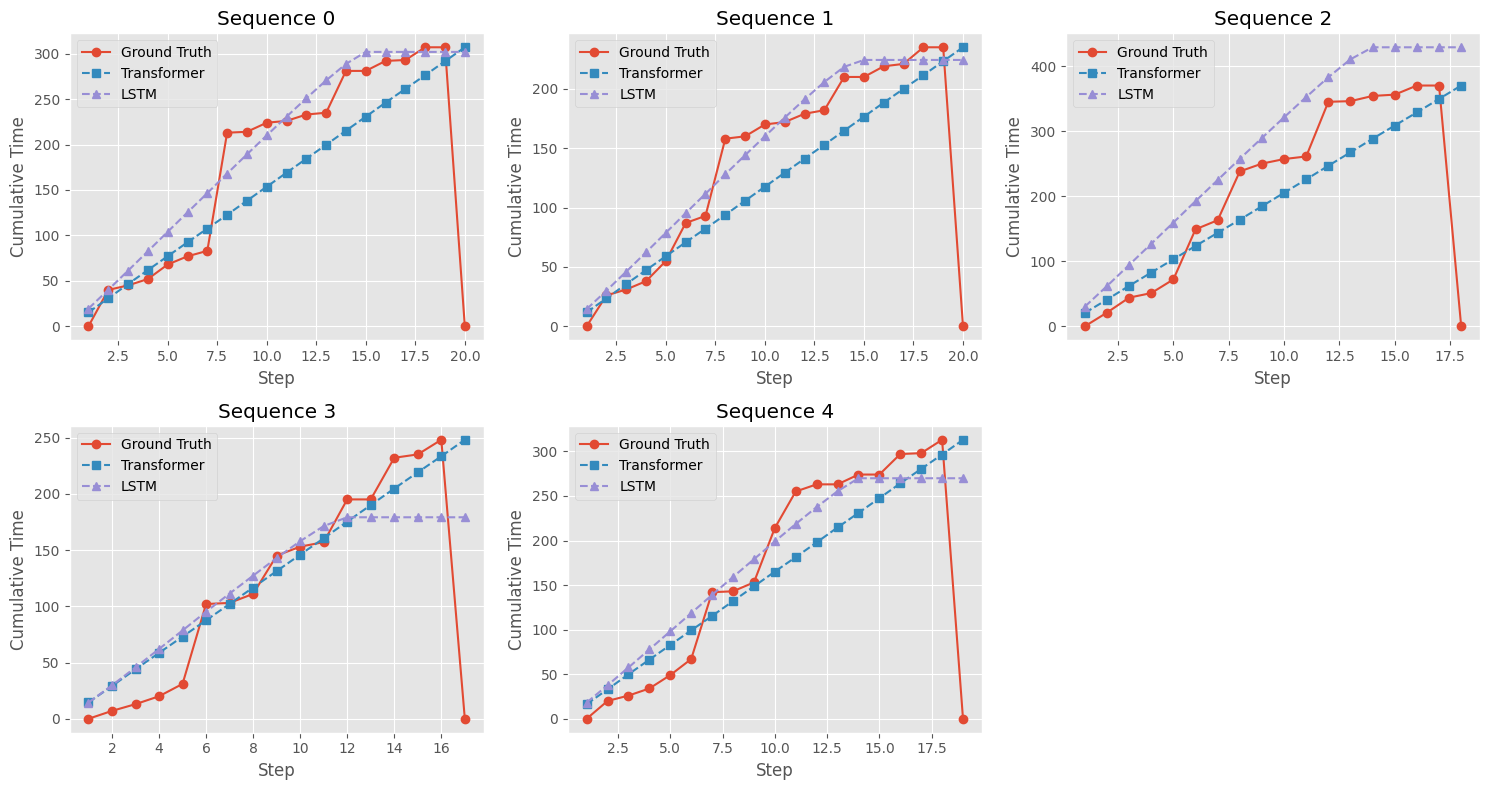

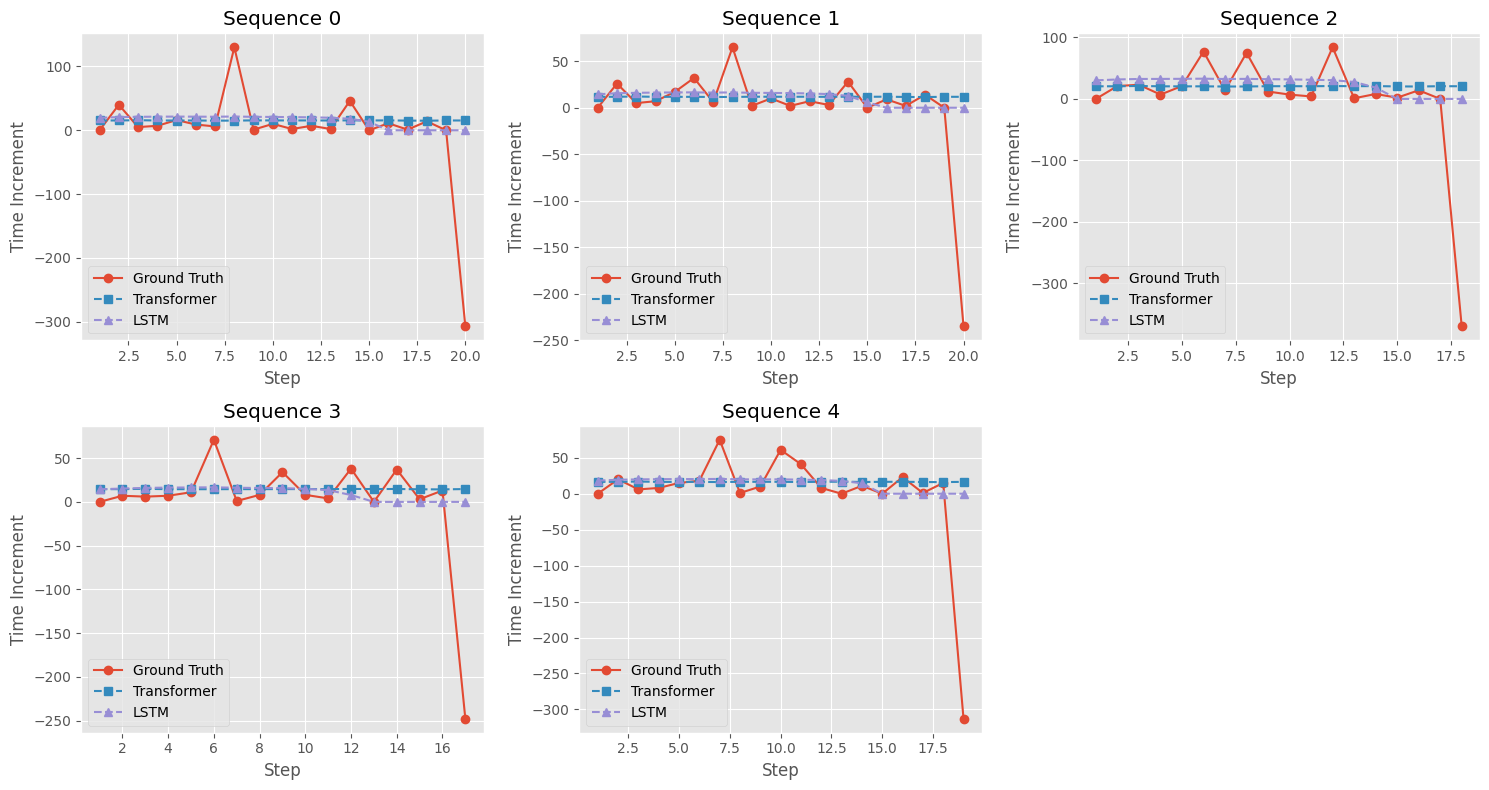

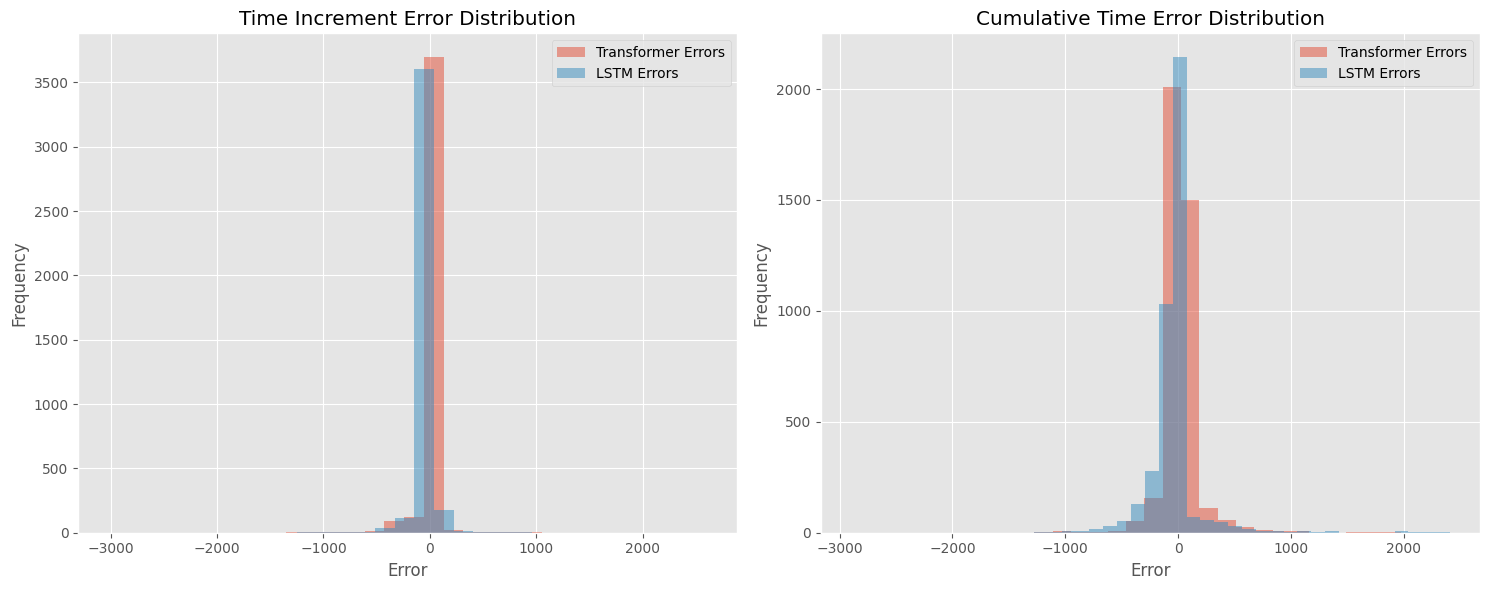

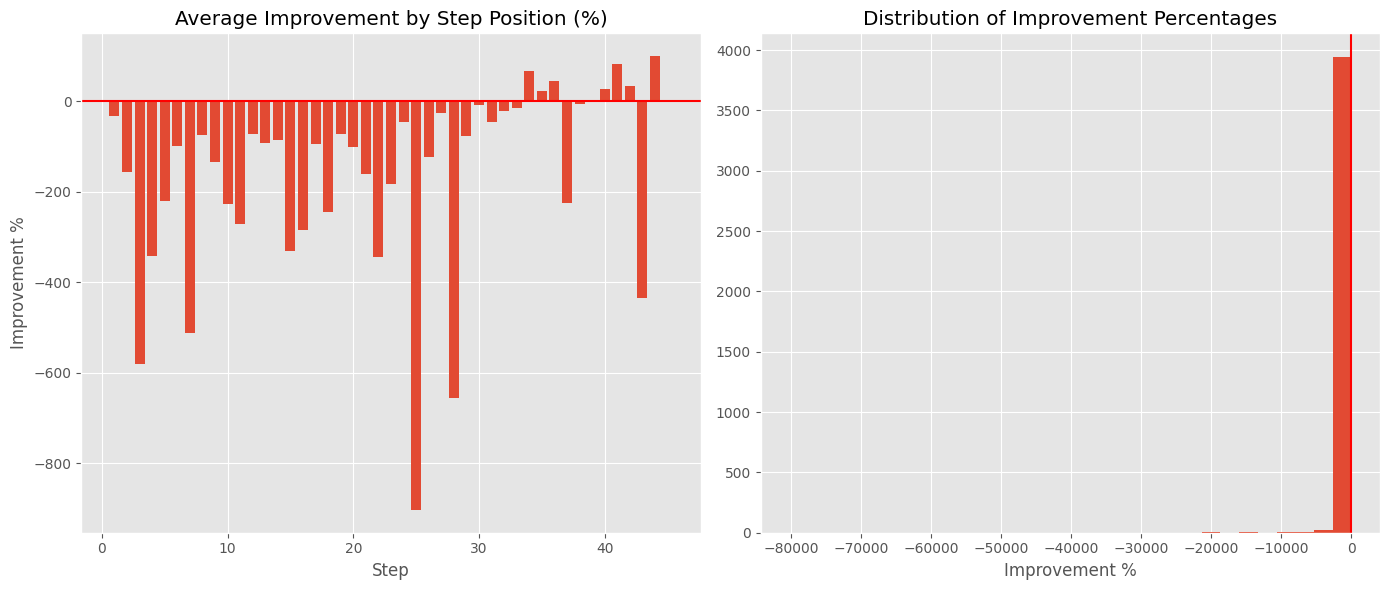

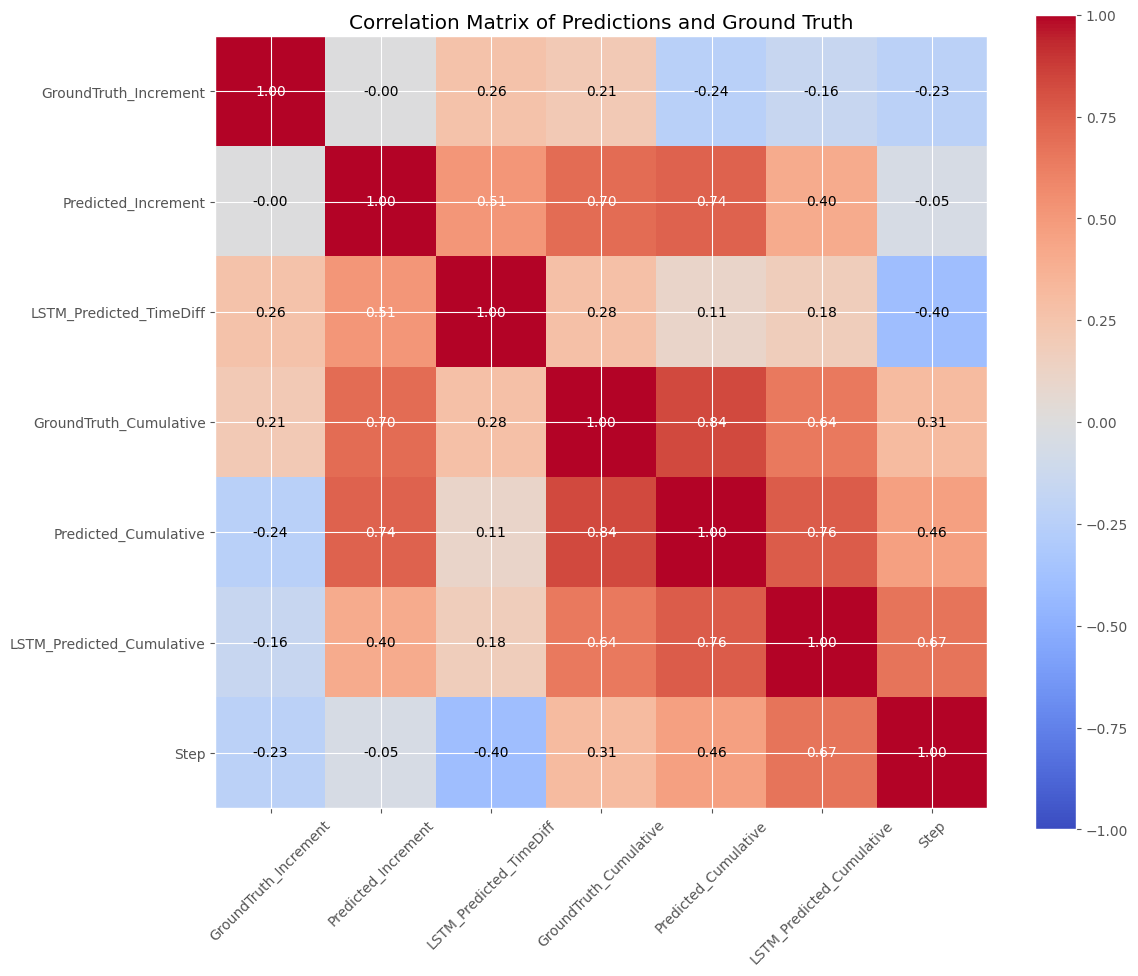

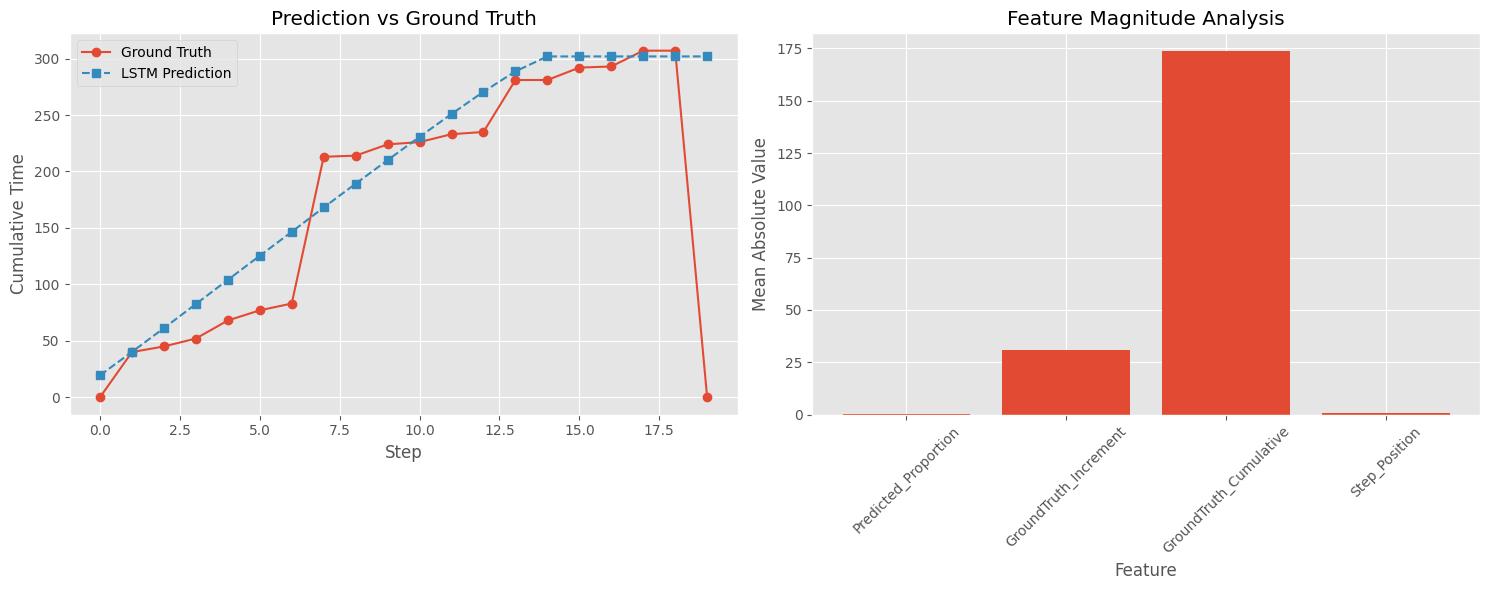

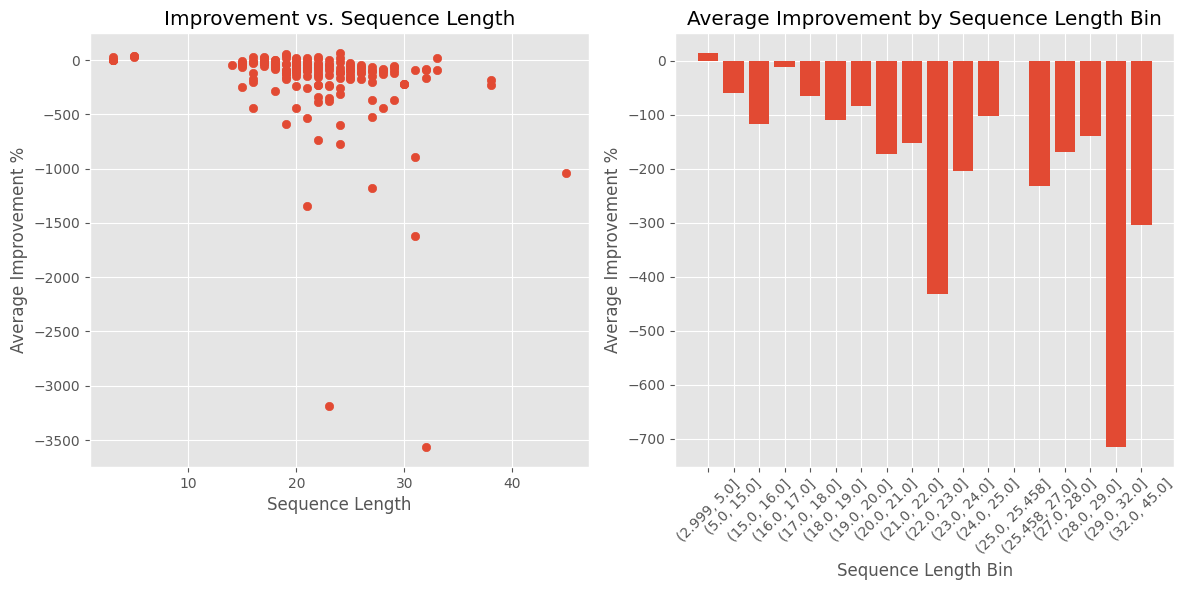

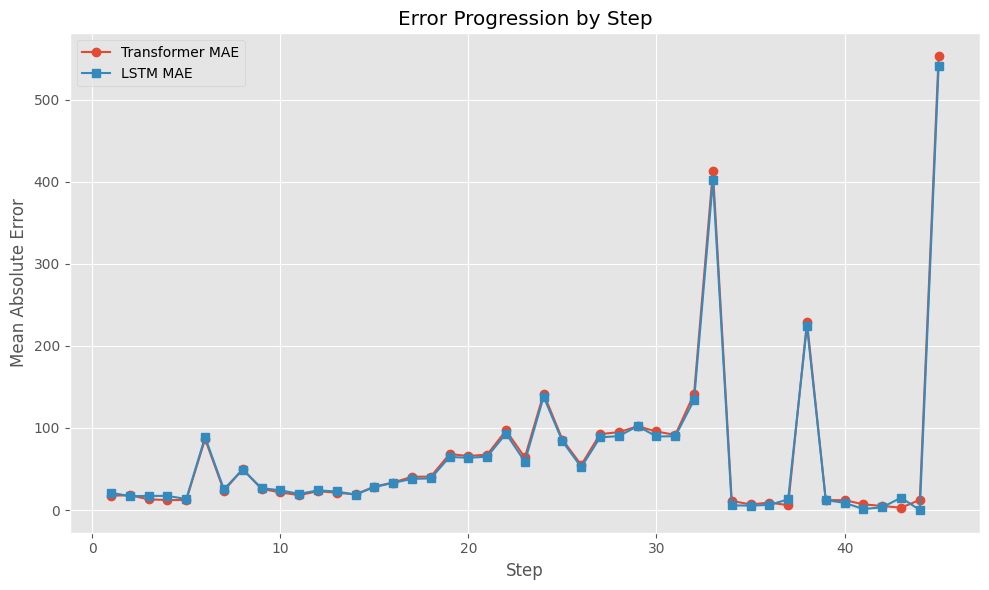

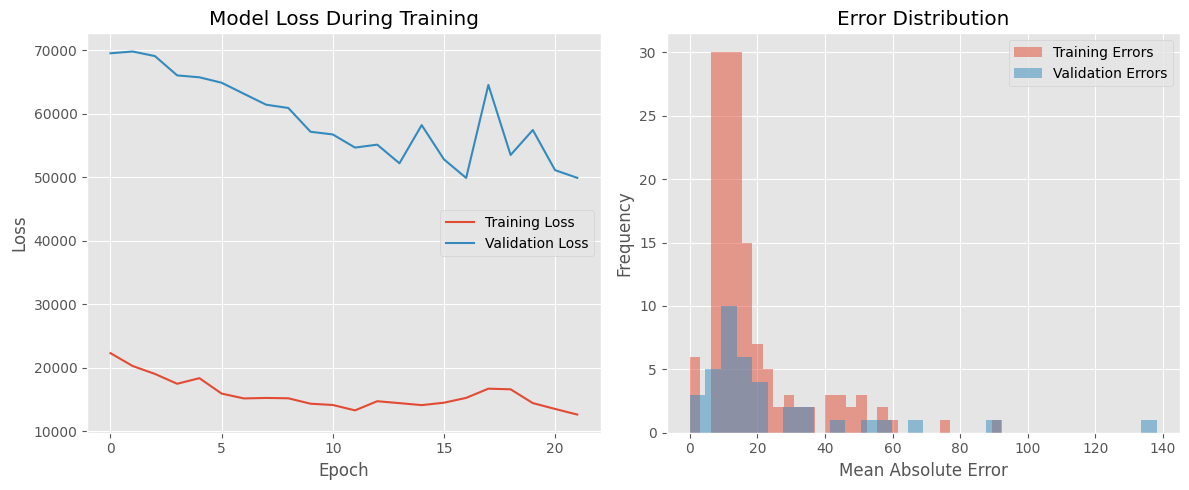

In [38]:
if __name__ == "__main__":
    main()